# Анализ тестовой выборки

Давайте сделаем предсказание на тестовой выборке. Для этого загрузим наши модель и токенайзер, возьмем тестовые данные из предобработанного файла *full_df.csv*, который мы получили в процессе тренировки модели, токенизируем тексты и отправим их в нейронную сеть. 

In [44]:
from keras.preprocessing.text import tokenizer_from_json
from keras.utils import pad_sequences, text_dataset_from_directory
from keras.models import load_model
import os

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import accuracy_score, confusion_matrix

In [7]:
model = load_model('imdbratings.h5')
with open('tokenizer.json', 'r') as f:
    tokenizer_json = f.read()
tokenizer = tokenizer_from_json(tokenizer_json)

In [49]:
test_df = pd.read_csv('full_df.csv', index_col='Unnamed: 0').iloc[25000:]

In [16]:
tokenized_text = tokenizer.texts_to_sequences(test_df.text)
test_data = pad_sequences(tokenized_text, maxlen=548, padding='post')
test_labels = test_df.rating

In [18]:
predictions = model.predict(test_data)

782/782 [==============================] - 19s 24ms/step


In [100]:
predictions[:5]

array([[0.8770803 ],
       [0.9917684 ],
       [0.0073953 ],
       [0.9871543 ],
       [0.10897158]], dtype=float32)

Результатом работы нейронной сети являются дробные числа. Их можно интерпретировать как *уверенность нейронной сети в том, что данный отзыв - положительный*. Поэтому нам нужно привести предсказания к бинарной форме: если модель уверена больше, чем на 50% - это положительный отзыв, если меньше - отрицательный.

In [32]:
bin_predictions = []
for x in predictions:
    if x > 0.5:
        bin_predictions.append(1)
    else:
        bin_predictions.append(0)

Итак, посчитаем точность предсказаний:

In [102]:
acc = np.round(accuracy_score(test_labels, bin_predictions) * 100)

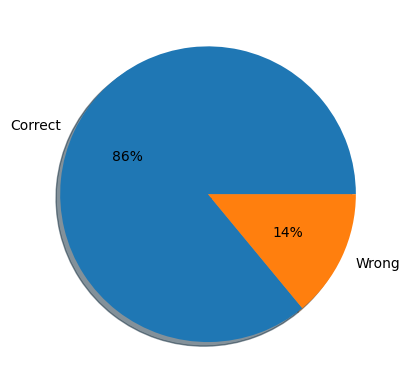

In [101]:
plt.pie(x=[acc, 100-acc], labels=['Correct', 'Wrong'], shadow=True, autopct='%1i%%');

## Модель точна в 86% случаев, что является отличным результатом. Но в чем она ошибается?

Давайте посмотрим, в каких отзывах модель ошибается больше - в положительных или отрицательных.

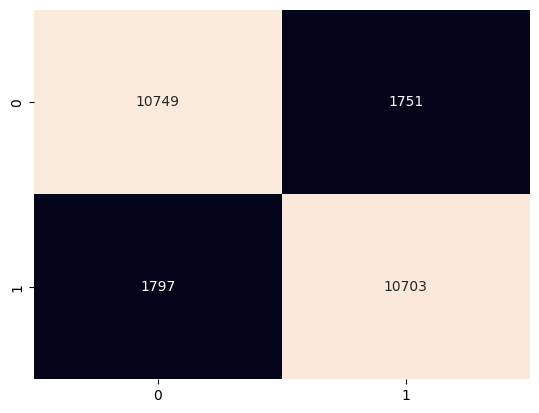

In [103]:
conf = confusion_matrix(test_labels, bin_predictions)
sns.heatmap(conf, annot=True, fmt='g', cbar=False);

Как мы видим, числа примерно равны. Давайте взглянем на те тексты, которые модель классифицировала неверно.

In [50]:
test_df[test_df.rating != bin_predictions]

,text,rating
0,sadly great opportunity utilise superb cast br...,0
4,truly scary film . happen curmudgeon james kun...,1
5,thing watchable corey performance lunatic kill...,0
9,read classic science fiction novel mini - seri...,0
24,"beautifully film , mind expand exploration gyp...",1
...,...,...
24950,"speck white shape , beautiful nude , random im...",0
24951,movie deserve . mike judge satirical wit bring...,1
24953,"ok , yes know philistine , knowledge , love op...",0
24969,evil man ( 1984 ) non - cannon film charlie br...,0


In [57]:
test_df.text[4]

'truly scary film . happen curmudgeon james kunstler rant lead recently - form web log like life oil crash ( latoc ) , energy bulletin , oil drum , datum theory hubbert peak . like film , latoc kunstler paint grim picture die - die - . hope premature , mid-2005 rise gasoline price , rise oil price , chevron join campaign , bp petroleum t boone picken lend credence idea near peak oil production . copious research limited datum , oil investment banker matt simmons suggest saudi long able increase production immense , age field . face increase demand ( primarily china ) , saudi respond high production , despite previous assurance . state world production 2000 2004 indicate light , sweet crude peak . mean refine costly . film aim baby boomer , young people , child , need understand implication energy - deplete future .'

In [60]:
test_df.text[5]

'thing watchable corey performance lunatic killer loose . remain impossible tale revenge matrimonial discord . walkie - talkie scene feel cotten squeeze sweet potato communication device . interesting thing alan hale ( skipper " gilligan island " ) fat , low arm waist . recommend .'

In [58]:
test_df.text[9]

'read classic science fiction novel mini - series base , actually good . unfortunately , fan book , probably able watch hour . political intrigue film , important scene book , character motivation change completely , word wrong character mouth . novel paul atredie teen age boy incredible political skill great understanding way world work , film hot head frustrate . avoid movie cost .'

In [59]:
test_df.text[24950]

'speck white shape , beautiful nude , random image . little experimental short film . kind interesting think early day film image transfer film , despite love lot surreal image film , fascination bizarre , film . I be sorry watch , underlie meaning , . visually , outstanding , humble opinion . example dadaism , suppose fit , reject semblance logic reason , prefer visually interesting way . .'

In [61]:
test_df.text[24951]

'movie deserve . mike judge satirical wit bring light country try deny ... dumb society . 24 - hour - - day anna nicole coverage proof ? mike judge paint frightening future , dumb survive thrive . stop think , laugh . look world ask dumb ? overtake human trash trash ? ( beware landslides).the movie funny . tell plot want spoil . release film zero promotion ? stupid ?'

Увидев эти примеры, становится понятно, почему модель иногда ошибается. Модель способна разделять тексты на "плохие" и "хорошие", но не учитывает контекст. Например, если фильм страшный или в нем фигурируют убийства, нейросеть решит, что это отрицательный отзыв - хотя для фильма ужасов это положительный отзыв. В другом случае рецензент долго расхваливает книгу, по которой был снят фильм, и лишь в конце говорит, что фильм получился неудачный. Из-за преобладания "хороших" слов модель выносит положительный вердикт. Также классификатор плохо работает с иронией, сарказмом и сатирой.

О том, что с этим делать, я расскажу в общем отчете о проделанной работе.